# Preparation

1. `git clone https://github.com/yang-song/score_sde_pytorch.git`

2. Install [required packages](https://github.com/yang-song/score_sde_pytorch/blob/main/requirements.txt)

3. `cd` into folder `score_sde_pytorch`, launch a local jupyter server and connect to colab following [these instructions](https://research.google.com/colaboratory/local-runtimes.html)

4. Download pre-trained [checkpoints](https://drive.google.com/drive/folders/1tFmF_uh57O6lx9ggtZT_5LdonVK2cV-e?usp=sharing) and save them in the `exp` folder.

In [1]:
import os

In [2]:
ls

 Volume in drive D is DATA
 Volume Serial Number is 36F3-BD02

 Directory of d:\Research\ContractiveDiffusion\score_sde_pytorch

2023/12/25  16:15    <DIR>          .
2023/12/24  17:38    <DIR>          ..
2023/12/19  16:02    <DIR>          .git
2023/12/19  16:00               254 .gitignore
2023/12/19  23:19    <DIR>          .ipynb_checkpoints
2023/12/25  16:24    <DIR>          __pycache__
2023/12/20  02:09    <DIR>          assets
2023/12/24  15:01    <DIR>          configs
2023/12/19  16:00             8,178 controllable_generation.py
2023/12/19  16:00             7,236 datasets.py
2023/12/24  15:29             1,167 debug.py
2023/12/19  16:00             4,952 evaluation.py
2023/12/22  01:26    <DIR>          exp
2023/12/19  16:00            11,357 LICENSE
2023/12/19  16:00             4,713 likelihood.py
2023/12/19  16:00             8,332 losses.py
2023/12/19  16:00             2,141 main.py
2023/12/19  16:05    <DIR>          models
2023/12/19  16:05    <DIR>          op
2023

In [4]:
#!pip install --upgrade pip
!pip install -r ./requirements_new.txt
# if GPU
!pip install --upgrade "jax[cpu]"

  Using cached tensorflow_probability-0.16.0-py2.py3-none-any.whl (6.3 MB)
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.13.0
    Uninstalling tensorflow-probability-0.13.0:
      Successfully uninstalled tensorflow-probability-0.13.0


In [19]:
for name in list(flags.FLAGS):
      delattr(flags.FLAGS,name)

In [2]:
!pip freeze | findstr torch

pytorch-fid==0.3.0
pytorch-gan-metrics==0.5.3
torch==2.1.2
torch-fidelity==0.3.0
torchaudio==2.1.2
torchmetrics @ file:///home/conda/feedstock_root/build_artifacts/torchmetrics_1701462872995/work
torchvision==0.16.2


In [ ]:
%run -i "main.py" --mode train --config configs/vp/cifar10_ddpmpp_continuous.py  --workdir test --config.training.batch_size=4

In [ ]:
%run -i 'main.py' --mode eval --config configs/vp/cifar10_ddpmpp_continuous.py  --workdir test

## Demo of Sampling

In [5]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      EulerMaruyamaPredictor,
                      AncestralSamplingPredictor,
                      NoneCorrector,
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

c:\Users\zhaoh\anaconda3\envs\diffusion_sde\lib\site-packages\torch\utils\cpp_extension.py:384: UserWarning: Error checking compiler version for cl: 'gbk' codec can't decode byte 0x84 in position 13: illegal multibyte sequence
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')


In [6]:
# @title Load the score-based model
sde = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
  from configs.ve import cifar10_ncsnpp_continuous as configs
  ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
  config = configs.get_config()
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1e-5
elif sde.lower() == 'vpsde':
  from configs.vp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = "exp/vp/cifar10_ddpmpp_continuous/checkpoint_8.pth"
  config = configs.get_config()
  sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
elif sde.lower() == 'subvpsde':
  from configs.subvp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = "exp/subvp/cifar10_ddpmpp_continuous/checkpoint_26.pth"
  config = configs.get_config()
  sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3

batch_size =   64#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [7]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


# Predictor Corrector sampling


Recommended settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


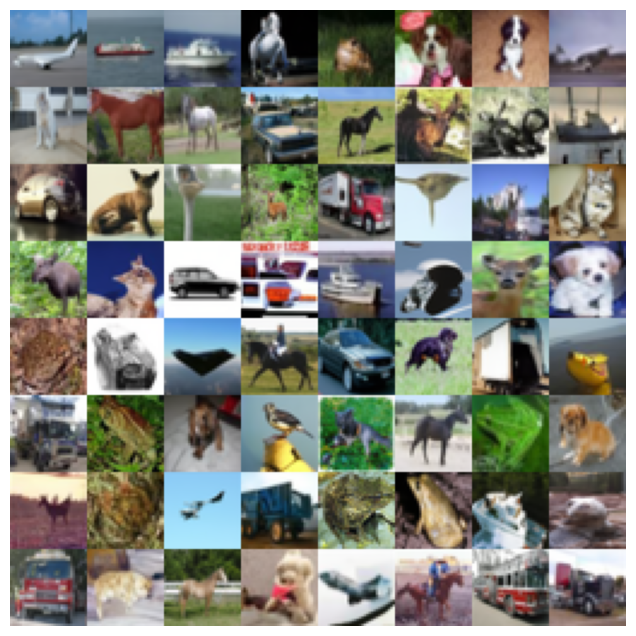

In [8]:
#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)
show_samples(x)

# Probability flow ODE

With black-box ODE solvers, we can produce samples, compute likelihoods, and obtain a uniquely identifiable encoding of any data point.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


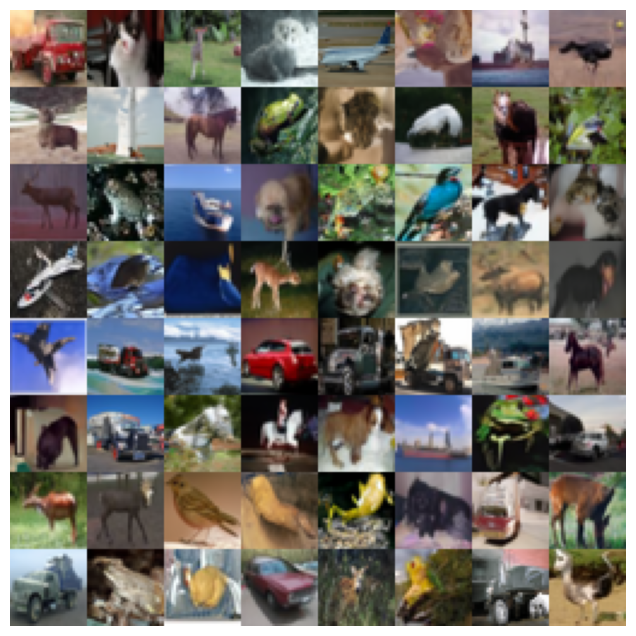

In [8]:
 #@title ODE sampling

shape = (batch_size, 3, 32, 32)
sampling_fn = sampling.get_ode_sampler(sde,
                                       shape,
                                       inverse_scaler,
                                       denoise=True,
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
show_samples(x)

# Computing evaluation statistics for FID/Inception score

### Source Code

In [ ]:
from configs.ve import celeba_ncsnpp_continuous as configs

config = configs.get_config()
os.makedirs('assets/stats', exist_ok=True)
stats_name = "celeba_stats.npz"  #@param {"type": "string"}
stats_name = os.path.join('assets/stats', stats_name)
rng = jax.random.PRNGKey(43)
config.eval.batch_size = 8

# Load data
train_ds, eval_ds, builder = datasets.get_dataset(config, evaluation=True)
ds_iter = iter(train_ds)
all_data = []
inception = evaluation.get_inception_model(inceptionv3=False)
count = 0
for data in tqdm.tqdm(iter(train_ds)):
  img = data['image']._numpy()
  all_data.append(img)
  count += img.shape[0]
  if count >= 50000:
    break
all_data = np.concatenate(all_data, axis=0)
all_data = all_data.reshape((-1, config.data.image_size, config.data.image_size, 3))
all_data = all_data[:50000, ...]

In [ ]:
# Feed into inception network
all_pool_3 = []
all_logits = []
for i in tqdm.notebook.tqdm(range(125)):
  stats = evaluation.run_inception_distributed(all_data[i * 400: (i+1)* 400] * 255.,
                                               inception,
                                               num_batches=1, inceptionv3=False)
  all_pool_3.append(stats['pool_3'])
all_pool_3 = np.concatenate([x._numpy() for x in all_pool_3], axis=0)

with tf.io.gfile.GFile(stats_name, "wb") as fout:
  io_buffer = io.BytesIO()
  np.savez_compressed(io_buffer, logits=all_logits, pool_3=all_pool_3)
  fout.write(io_buffer.getvalue())

## Compute FID score

### 1. FID score in Song

In [69]:
cifar10_stats_name = "cifar10_stats.npz"  #@param {"type": "string"}
cifar10_stats_path = os.path.join('assets/stats', cifar10_stats_name)
cifar10_stat = np.load(cifar10_stats_path)

In [71]:
cifar10_stat['pool_3'].shape

(50000, 2048)

In [72]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [73]:
calculate_fid(cifar10_stat['pool_3'],cifar10_stat['pool_3'])

-2.3976150925753004e-12

### 2. FID score outside implementation

In [61]:
all_data_IS.shape

torch.Size([50000, 3, 32, 32])

In [67]:
cifar10_train_stats_name = "fid_stats_cifar10_train.npz"  #@param {"type": "string"}
cifar10_train_stats_path = os.path.join('assets/stats', cifar10_train_stats_name)

In [68]:
FID = get_fid(all_data_IS, cifar10_train_stats_path)

In [63]:
FID

0.26709963982244744

## Compute IS score

In [51]:
from pytorch_gan_metrics import get_inception_score, get_fid
IS, IS_std = get_inception_score(all_data_IS)

Downloading: "https://github.com/w86763777/pytorch-gan-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to C:\Users\zhaoh/.cache\torch\hub\checkpoints\pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:08<00:00, 11.8MB/s]


In [53]:
IS,IS_std

(11.272810050817098, 0.11701868790204545)